<a href="https://colab.research.google.com/github/dinabahar/analyticstest_giantspoon/blob/master/3_predict_march.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Predict March Purchases

### I. Imports

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### II. Read `merged_data`

In [152]:
df = pd.read_csv('/content/drive/My Drive/giant_spoon_analytics_test/merged_data.csv')
df.head()

,date,platform,placement,spend,impressions,clicks,add_to_cart,purchase,revenue
0,2019-01-04,instagram,LAL_CHI_Purchase,6.63,1339,4,0.0,0.0,0.0
1,2019-01-04,facebook,RTG_NYC_Cart Add,3.17,133,1,0.0,0.0,0.0
2,2019-01-04,instagram,LAL_NYC_Purchase,10.11,2389,14,1.0,1.0,70.0
3,2019-01-04,facebook,LAL_DC_Purchase,3.14,378,2,0.0,0.0,0.0
4,2019-01-04,facebook,RTG_CHI_Cart Add,14.41,2488,10,1.0,1.0,143.0


In [153]:
march = pd.read_csv('/content/drive/My Drive/giant_spoon_analytics_test/march_dates.csv')
march.head()

,date,purchase
0,2019-03-01,NaN
1,2019-03-02,NaN
2,2019-03-03,NaN
3,2019-03-04,NaN
4,2019-03-05,NaN


### III. Data prep
- Set `'date'` as index
- Group purchase data by date
- Create March data for predictions

In [154]:
df['date'] = pd.to_datetime(df['date'])
march['date'] = pd.to_datetime(march['date'])

purchases = df.groupby('date')[['purchase']].mean()
march = march.set_index('date')

purchases = pd.concat([purchases, march], axis=0)

purchases

,purchase
date,
2019-01-04,0.208333
2019-01-05,0.500000
2019-01-06,0.166667
2019-01-07,0.333333
2019-01-08,0.458333
...,...
2019-03-27,NaN
2019-03-28,NaN
2019-03-29,NaN


### IV. Check for seasonality

There's a weekly pattern.

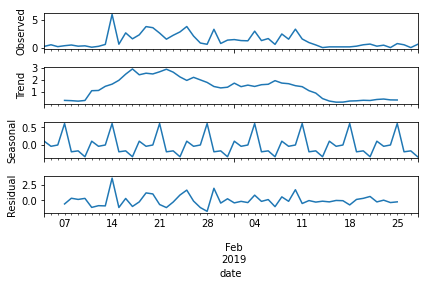

In [155]:
decomp = seasonal_decompose(purchases['purchase'].dropna())

decomp.plot();

### V. Plot ACF & PACF to see how much to lag.

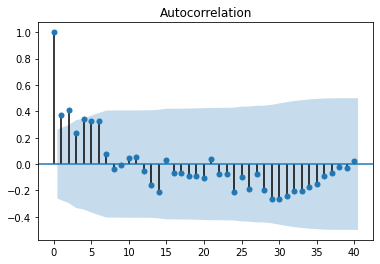

In [156]:
plot_acf(purchases['purchase'].dropna(), lags = 40);

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1350: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k] * X[k:]).sum() / denom(k)


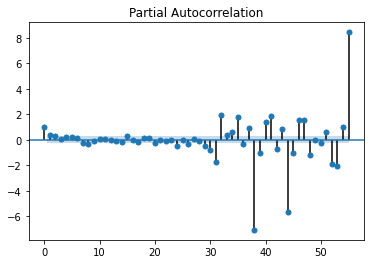

In [157]:
plot_pacf(purchases['purchase'].dropna(), lags = 60);

### VI. Shift 38 times.

Create a column called `lag_38` that lags purchases by 38 days.

In [158]:
purchases['lag_38'] = purchases['purchase'].shift(38)

purchases.head()

,purchase,lag_38
date,,
2019-01-04,0.208333,NaN
2019-01-05,0.500000,NaN
2019-01-06,0.166667,NaN
2019-01-07,0.333333,NaN
2019-01-08,0.458333,NaN


In [159]:
purchases.tail()

,purchase,lag_38
date,,
2019-03-27,NaN,0.125
2019-03-28,NaN,0.125
2019-03-29,NaN,0.250
2019-03-30,NaN,0.500
2019-03-31,NaN,0.625


### VI. Pre-Modeling

Train/test split.

In [160]:
# Separate established data (Jan - Feb) from forecasting data (Mar)
modeling_data = purchases[:-31]

X_train, X_test, y_train, y_test = train_test_split(modeling_data.drop(columns = 'purchase'),
                                                    modeling_data['purchase'],
                                                    test_size = 0.25,
                                                    shuffle = False)

In [161]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42, 1)
(14, 1)
(42,)
(14,)


Add constant to model with statsmodels.

In [162]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

Drop missing values (from shifting data) because statsmodels won't work on missing values. Subset y_train to keep only indices from X_train.

In [163]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index] 

### VII. Instantiate & fit model

Interpreting Summary:

- All else held constant, 

In [173]:
lm = sm.OLS(y_train, X_train)
lm_results = lm.fit()

In [166]:
r2_score(y_test, lm_results.predict(X_test))

-16.03612964416618

In [167]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

0.95760184686084

### VIII. Plot model predictions

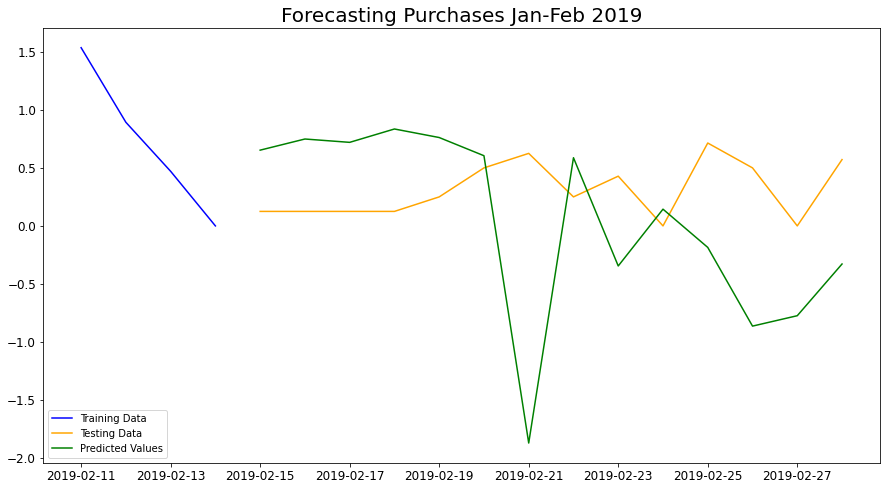

In [174]:
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue', label = 'Training Data')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange', label = 'Testing Data')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green', label = 'Predicted Values')

# Set label.
plt.title(label = 'Forecasting Purchases Jan-Feb 2019', fontsize=20)

# Resize tick marks.
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc="lower left")

plt.savefig('/content/drive/My Drive/giant_spoon_analytics_test/model.png',dpi=235,bbox_inches='tight');

### IX. Prep march data for forecasting

In [175]:
predict_march = purchases[56:]
predict_march = predict_march.drop(columns='purchase')
predict_march = sm.add_constant(predict_march)
predict_march.head()

,const,lag_38
date,,
2019-03-01,1.0,1.500000
2019-03-02,1.0,2.200000
2019-03-03,1.0,2.800000
2019-03-04,1.0,3.764706
2019-03-05,1.0,2.058824


### X. Plot March forecast

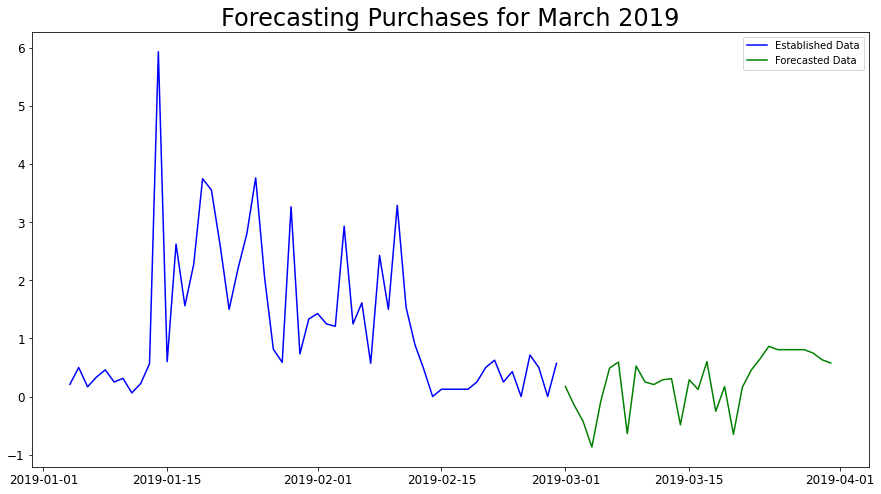

In [172]:
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(modeling_data.index, modeling_data['purchase'], color = 'blue', label = 'Established Data')

# Plot predicted test values.
plt.plot(lm_results.predict(predict_march), color = 'green', label = 'Forecasted Data')

# Set label.
plt.title(label = 'Forecasting Purchases for March 2019', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc="upper right")

plt.savefig('/content/drive/My Drive/giant_spoon_analytics_test/forecast.png',dpi=235,bbox_inches='tight');

### XI. Save predictions

In [177]:
pd.DataFrame(lm_results.predict(predict_march)).to_csv('/content/drive/My Drive/giant_spoon_analytics_test/march_predictions.csv')